### Problem 2

In [3]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.5 MB/s eta 0:00:00


In [8]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 136.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=75ccc8edbecec80ac6a6fd93e3501f1c74d1b99446c289a5c4548a2981fbad73
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, models

# MedMNIST for the dataset
import medmnist
from medmnist import INFO, Evaluator

from sklearn.metrics import roc_auc_score, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
import copy

# For Grad-CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# For Quantization
import torch.quantization
from torch.ao.quantization import QuantStub, DeQuantStub

In [10]:
# Setup
STUDENT_ID = "018195489" # Sreenidhi Hayagreevan Sudent id is 018195489 --> odd number. Hense choosing ChestMNIST dataset.
DATASET_NAME = 'chestmnist'

info = INFO[DATASET_NAME]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
labels = info['label']

# Training parameters
BATCH_SIZE = 128
EPOCHS = 100
LR = 0.001

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Path to save models
MODEL_PATH = "models"
os.makedirs(MODEL_PATH, exist_ok=True)

Using device: cuda


In [11]:
# Data Loading and Transformations
# Defining data transformations

data_transform_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]) # Normalize for grayscale
])

# Define transformations with data augmentation for 2a
data_transform_with_aug = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Downloading and preparing datasets
print(f"Loading {DATASET_NAME} dataset...")
DataClass = getattr(medmnist, info['python_class'])

# Datasets without augmentation
train_dataset_no_aug = DataClass(split='train', transform=data_transform_no_aug, download=True)
val_dataset = DataClass(split='val', transform=data_transform_no_aug, download=True)

# Dataset with augmentation for training
train_dataset_with_aug = DataClass(split='train', transform=data_transform_with_aug, download=True)

# Test dataset remains the same
test_dataset = DataClass(split='test', transform=data_transform_no_aug, download=True)

# Create DataLoaders
# The 'train_loader' will be redefined in part 2a based on augmentation
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Loading chestmnist dataset...


100%|██████████| 82.8M/82.8M [00:59<00:00, 1.39MB/s]


In [12]:
# Functions (Training, Evaluation, Plotting)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, model_save_path):
    """General function to train a model with early stopping."""
    # Initialize trackers for learning curves
    train_losses, val_losses = [], []

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=15, verbose=True, path=model_save_path)

    # Start timer
    start_time = time.time()

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).float()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).float()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # Early stopping check
        early_stopping(epoch_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
    end_time = time.time()
    print(f"Training finished in {end_time - start_time:.2f} seconds.")

    return train_losses, val_losses


def evaluate_model(model, data_loader):
    """Evaluate model performance on a given dataset."""
    model.eval()
    model_device = next(model.parameters()).device
    all_preds = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_preds.append(preds.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)

    evaluator = Evaluator(DATASET_NAME, 'test')
    metrics = evaluator.evaluate(all_preds)

    auc = metrics[0]
    acc = metrics[1]

    return auc, acc

def evaluate_quantized_model(model, data_loader):
    """Evaluate a quantized model on the CPU."""
    model.eval()
    all_preds = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to("cpu") # Ensure data is on CPU
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_preds.append(preds.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)

    evaluator = Evaluator(DATASET_NAME, 'test')
    metrics = evaluator.evaluate(all_preds)

    auc = metrics[0]
    acc = metrics[1]

    return auc, acc


def plot_learning_curves(history_tuple, title):
    """Plots training and validation loss curves."""
    train_losses, val_losses = history_tuple
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

#### 2a)


------------------------------
2a - Deep CNN
------------------------------

Training CNN without Data Augmentation


Epoch 1/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.20it/s]


Epoch 1/100 | Train Loss: 0.1791 | Val Loss: 0.1687
Validation loss decreased (inf --> 0.168735).  Saving model ...


Epoch 2/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.70it/s]


Epoch 2/100 | Train Loss: 0.1716 | Val Loss: 0.1649
Validation loss decreased (0.168735 --> 0.164905).  Saving model ...


Epoch 3/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.47it/s]


Epoch 3/100 | Train Loss: 0.1677 | Val Loss: 0.1647
Validation loss decreased (0.164905 --> 0.164665).  Saving model ...


Epoch 4/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.61it/s]


Epoch 4/100 | Train Loss: 0.1654 | Val Loss: 0.1679
EarlyStopping counter: 1 out of 15


Epoch 5/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.99it/s]


Epoch 5/100 | Train Loss: 0.1636 | Val Loss: 0.1618
Validation loss decreased (0.164665 --> 0.161790).  Saving model ...


Epoch 6/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.64it/s]


Epoch 6/100 | Train Loss: 0.1613 | Val Loss: 0.1616
Validation loss decreased (0.161790 --> 0.161593).  Saving model ...


Epoch 7/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.77it/s]


Epoch 7/100 | Train Loss: 0.1592 | Val Loss: 0.1622
EarlyStopping counter: 1 out of 15


Epoch 8/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.19it/s]


Epoch 8/100 | Train Loss: 0.1567 | Val Loss: 0.1604
Validation loss decreased (0.161593 --> 0.160447).  Saving model ...


Epoch 9/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.83it/s]


Epoch 9/100 | Train Loss: 0.1541 | Val Loss: 0.1615
EarlyStopping counter: 1 out of 15


Epoch 10/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.51it/s]


Epoch 10/100 | Train Loss: 0.1510 | Val Loss: 0.1641
EarlyStopping counter: 2 out of 15


Epoch 11/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.41it/s]


Epoch 11/100 | Train Loss: 0.1473 | Val Loss: 0.1648
EarlyStopping counter: 3 out of 15


Epoch 12/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.36it/s]


Epoch 12/100 | Train Loss: 0.1438 | Val Loss: 0.1671
EarlyStopping counter: 4 out of 15


Epoch 13/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 45.11it/s]


Epoch 13/100 | Train Loss: 0.1386 | Val Loss: 0.1740
EarlyStopping counter: 5 out of 15


Epoch 14/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.83it/s]


Epoch 14/100 | Train Loss: 0.1334 | Val Loss: 0.1741
EarlyStopping counter: 6 out of 15


Epoch 15/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 45.13it/s]


Epoch 15/100 | Train Loss: 0.1273 | Val Loss: 0.1810
EarlyStopping counter: 7 out of 15


Epoch 16/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.71it/s]


Epoch 16/100 | Train Loss: 0.1222 | Val Loss: 0.2049
EarlyStopping counter: 8 out of 15


Epoch 17/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 45.31it/s]


Epoch 17/100 | Train Loss: 0.1148 | Val Loss: 0.2021
EarlyStopping counter: 9 out of 15


Epoch 18/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.11it/s]


Epoch 18/100 | Train Loss: 0.1083 | Val Loss: 0.2012
EarlyStopping counter: 10 out of 15


Epoch 19/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.62it/s]


Epoch 19/100 | Train Loss: 0.1033 | Val Loss: 0.2179
EarlyStopping counter: 11 out of 15


Epoch 20/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.90it/s]


Epoch 20/100 | Train Loss: 0.0958 | Val Loss: 0.2476
EarlyStopping counter: 12 out of 15


Epoch 21/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.54it/s]


Epoch 21/100 | Train Loss: 0.0907 | Val Loss: 0.2402
EarlyStopping counter: 13 out of 15


Epoch 22/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.97it/s]


Epoch 22/100 | Train Loss: 0.0861 | Val Loss: 0.2684
EarlyStopping counter: 14 out of 15


Epoch 23/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.99it/s]


Epoch 23/100 | Train Loss: 0.0790 | Val Loss: 0.2909
EarlyStopping counter: 15 out of 15
Early stopping triggered.
Training finished in 407.46 seconds.

Evaluating CNN without Augmentation on Test Data
Test AUC: 0.7606, Test Accuracy: 0.9479


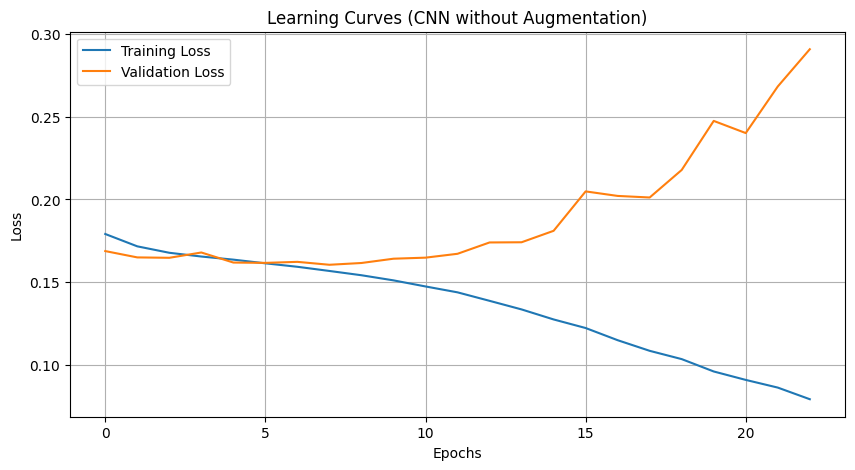


Training CNN with Data Augmentation


Epoch 1/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.27it/s]


Epoch 1/100 | Train Loss: 0.1814 | Val Loss: 0.1716
Validation loss decreased (inf --> 0.171569).  Saving model ...


Epoch 2/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 42.83it/s]


Epoch 2/100 | Train Loss: 0.1758 | Val Loss: 0.1674
Validation loss decreased (0.171569 --> 0.167357).  Saving model ...


Epoch 3/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.93it/s]


Epoch 3/100 | Train Loss: 0.1729 | Val Loss: 0.1740
EarlyStopping counter: 1 out of 15


Epoch 4/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.40it/s]


Epoch 4/100 | Train Loss: 0.1711 | Val Loss: 0.1652
Validation loss decreased (0.167357 --> 0.165171).  Saving model ...


Epoch 5/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.92it/s]


Epoch 5/100 | Train Loss: 0.1692 | Val Loss: 0.1636
Validation loss decreased (0.165171 --> 0.163563).  Saving model ...


Epoch 6/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.91it/s]


Epoch 6/100 | Train Loss: 0.1678 | Val Loss: 0.1638
EarlyStopping counter: 1 out of 15


Epoch 7/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.31it/s]


Epoch 7/100 | Train Loss: 0.1668 | Val Loss: 0.1647
EarlyStopping counter: 2 out of 15


Epoch 8/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.39it/s]


Epoch 8/100 | Train Loss: 0.1660 | Val Loss: 0.1630
Validation loss decreased (0.163563 --> 0.162993).  Saving model ...


Epoch 9/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.84it/s]


Epoch 9/100 | Train Loss: 0.1650 | Val Loss: 0.1640
EarlyStopping counter: 1 out of 15


Epoch 10/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.03it/s]


Epoch 10/100 | Train Loss: 0.1644 | Val Loss: 0.1618
Validation loss decreased (0.162993 --> 0.161806).  Saving model ...


Epoch 11/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.87it/s]


Epoch 11/100 | Train Loss: 0.1638 | Val Loss: 0.1621
EarlyStopping counter: 1 out of 15


Epoch 12/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.88it/s]


Epoch 12/100 | Train Loss: 0.1631 | Val Loss: 0.1604
Validation loss decreased (0.161806 --> 0.160386).  Saving model ...


Epoch 13/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.25it/s]


Epoch 13/100 | Train Loss: 0.1623 | Val Loss: 0.1612
EarlyStopping counter: 1 out of 15


Epoch 14/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.42it/s]


Epoch 14/100 | Train Loss: 0.1616 | Val Loss: 0.1610
EarlyStopping counter: 2 out of 15


Epoch 15/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.44it/s]


Epoch 15/100 | Train Loss: 0.1613 | Val Loss: 0.1603
Validation loss decreased (0.160386 --> 0.160272).  Saving model ...


Epoch 16/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.46it/s]


Epoch 16/100 | Train Loss: 0.1603 | Val Loss: 0.1600
Validation loss decreased (0.160272 --> 0.159989).  Saving model ...


Epoch 17/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.01it/s]


Epoch 17/100 | Train Loss: 0.1599 | Val Loss: 0.1601
EarlyStopping counter: 1 out of 15


Epoch 18/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.06it/s]


Epoch 18/100 | Train Loss: 0.1594 | Val Loss: 0.1597
Validation loss decreased (0.159989 --> 0.159719).  Saving model ...


Epoch 19/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.19it/s]


Epoch 19/100 | Train Loss: 0.1587 | Val Loss: 0.1605
EarlyStopping counter: 1 out of 15


Epoch 20/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.66it/s]


Epoch 20/100 | Train Loss: 0.1580 | Val Loss: 0.1616
EarlyStopping counter: 2 out of 15


Epoch 21/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.57it/s]


Epoch 21/100 | Train Loss: 0.1575 | Val Loss: 0.1625
EarlyStopping counter: 3 out of 15


Epoch 22/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.72it/s]


Epoch 22/100 | Train Loss: 0.1569 | Val Loss: 0.1615
EarlyStopping counter: 4 out of 15


Epoch 23/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.54it/s]


Epoch 23/100 | Train Loss: 0.1563 | Val Loss: 0.1609
EarlyStopping counter: 5 out of 15


Epoch 24/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.62it/s]


Epoch 24/100 | Train Loss: 0.1558 | Val Loss: 0.1603
EarlyStopping counter: 6 out of 15


Epoch 25/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.94it/s]


Epoch 25/100 | Train Loss: 0.1550 | Val Loss: 0.1609
EarlyStopping counter: 7 out of 15


Epoch 26/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.26it/s]


Epoch 26/100 | Train Loss: 0.1550 | Val Loss: 0.1611
EarlyStopping counter: 8 out of 15


Epoch 27/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.66it/s]


Epoch 27/100 | Train Loss: 0.1540 | Val Loss: 0.1628
EarlyStopping counter: 9 out of 15


Epoch 28/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.41it/s]


Epoch 28/100 | Train Loss: 0.1534 | Val Loss: 0.1628
EarlyStopping counter: 10 out of 15


Epoch 29/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.20it/s]


Epoch 29/100 | Train Loss: 0.1534 | Val Loss: 0.1636
EarlyStopping counter: 11 out of 15


Epoch 30/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.62it/s]


Epoch 30/100 | Train Loss: 0.1525 | Val Loss: 0.1624
EarlyStopping counter: 12 out of 15


Epoch 31/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.20it/s]


Epoch 31/100 | Train Loss: 0.1519 | Val Loss: 0.1634
EarlyStopping counter: 13 out of 15


Epoch 32/100 [Val]: 100%|██████████| 88/88 [00:01<00:00, 44.30it/s]


Epoch 32/100 | Train Loss: 0.1510 | Val Loss: 0.1630
EarlyStopping counter: 14 out of 15


Epoch 33/100 [Val]: 100%|██████████| 88/88 [00:02<00:00, 43.70it/s]


Epoch 33/100 | Train Loss: 0.1504 | Val Loss: 0.1638
EarlyStopping counter: 15 out of 15
Early stopping triggered.
Training finished in 1512.94 seconds.

Evaluating CNN with Augmentation on Test Data
Test AUC: 0.7588, Test Accuracy: 0.9478


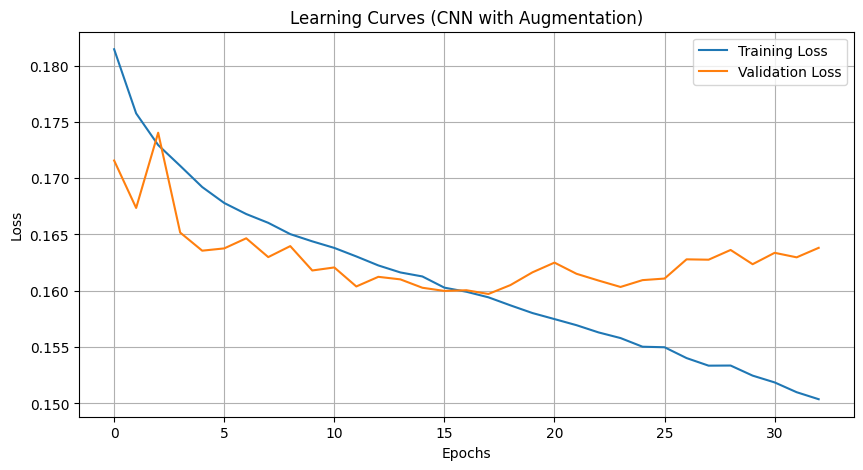

In [13]:
print("\n" + "-"*30)
print("2a - Deep CNN")
print("-"*30)

class DeepCNN_with_3_cl(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DeepCNN_with_3_cl, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_block = nn.Sequential(
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Adding stubs for static quantization
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.pool(self.conv_block1(x))
        x = self.pool(self.conv_block2(x))
        x = self.pool(self.conv_block3(x))
        x = self.conv_block4(x)
        x = x.reshape(-1, 256 * 3 * 3)
        x = self.fc_block(x)
        x = self.dequant(x) # End quantization
        return x

# Train CNN without Augmentation
print("\nTraining CNN without Data Augmentation")
train_loader_no_aug = DataLoader(dataset=train_dataset_no_aug, batch_size=BATCH_SIZE, shuffle=True)
model_no_aug = DeepCNN_with_3_cl(in_channels=n_channels, num_classes=n_classes).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_no_aug.parameters(), lr=LR)
model_no_aug_path = os.path.join(MODEL_PATH, "cnn_no_aug.pt")
history_no_aug = train_model(
    model_no_aug, train_loader_no_aug, val_loader, criterion, optimizer, EPOCHS, model_no_aug_path
)

print("\nEvaluating CNN without Augmentation on Test Data")
model_to_eval_no_aug = DeepCNN_with_3_cl(in_channels=n_channels, num_classes=n_classes).to(DEVICE)
model_to_eval_no_aug.load_state_dict(torch.load(model_no_aug_path))
auc_no_aug, acc_no_aug = evaluate_model(model_to_eval_no_aug, test_loader)
print(f"Test AUC: {auc_no_aug:.4f}, Test Accuracy: {acc_no_aug:.4f}")
plot_learning_curves(history_no_aug, "Learning Curves (CNN without Augmentation)")

# Train CNN with Augmentation
print("\nTraining CNN with Data Augmentation")
train_loader_with_aug = DataLoader(dataset=train_dataset_with_aug, batch_size=BATCH_SIZE, shuffle=True)
model_with_aug = DeepCNN_with_3_cl(in_channels=n_channels, num_classes=n_classes).to(DEVICE)
optimizer = optim.Adam(model_with_aug.parameters(), lr=LR)
model_with_aug_path = os.path.join(MODEL_PATH, "cnn_with_aug.pt")
history_with_aug = train_model(
    model_with_aug, train_loader_with_aug, val_loader, criterion, optimizer, EPOCHS, model_with_aug_path
)

print("\nEvaluating CNN with Augmentation on Test Data")
model_to_eval_with_aug = DeepCNN_with_3_cl(in_channels=n_channels, num_classes=n_classes).to(DEVICE)
model_to_eval_with_aug.load_state_dict(torch.load(model_with_aug_path))
auc_with_aug, acc_with_aug = evaluate_model(model_to_eval_with_aug, test_loader)
print(f"Test AUC: {auc_with_aug:.4f}, Test Accuracy: {acc_with_aug:.4f}")
plot_learning_curves(history_with_aug, "Learning Curves (CNN with Augmentation)")

In [14]:
print(f"Without Augmentation -> AUC: {auc_no_aug:.4f}, Accuracy: {acc_no_aug:.4f}")
print(f"With Augmentation    -> AUC: {auc_with_aug:.4f}, Accuracy: {acc_with_aug:.4f}")

Without Augmentation -> AUC: 0.7606, Accuracy: 0.9479
With Augmentation    -> AUC: 0.7588, Accuracy: 0.9478


### 2b)


------------------------------
2b - Transfer Learning with VGG-16
------------------------------

1: Training VGG-16 with all conv layers frozen


Epoch 1/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.73it/s]


Epoch 1/100 | Train Loss: 0.1806 | Val Loss: 0.1734
Validation loss decreased (inf --> 0.173353).  Saving model ...


Epoch 2/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.74it/s]


Epoch 2/100 | Train Loss: 0.1745 | Val Loss: 0.1695
Validation loss decreased (0.173353 --> 0.169507).  Saving model ...


Epoch 3/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.65it/s]


Epoch 3/100 | Train Loss: 0.1735 | Val Loss: 0.1691
Validation loss decreased (0.169507 --> 0.169068).  Saving model ...


Epoch 4/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.87it/s]


Epoch 4/100 | Train Loss: 0.1729 | Val Loss: 0.1687
Validation loss decreased (0.169068 --> 0.168663).  Saving model ...


Epoch 5/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.73it/s]


Epoch 5/100 | Train Loss: 0.1724 | Val Loss: 0.1678
Validation loss decreased (0.168663 --> 0.167850).  Saving model ...


Epoch 6/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.70it/s]


Epoch 6/100 | Train Loss: 0.1721 | Val Loss: 0.1679
EarlyStopping counter: 1 out of 15


Epoch 7/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.75it/s]


Epoch 7/100 | Train Loss: 0.1716 | Val Loss: 0.1678
Validation loss decreased (0.167850 --> 0.167756).  Saving model ...


Epoch 8/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.67it/s]


Epoch 8/100 | Train Loss: 0.1716 | Val Loss: 0.1675
Validation loss decreased (0.167756 --> 0.167451).  Saving model ...


Epoch 9/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.90it/s]


Epoch 9/100 | Train Loss: 0.1712 | Val Loss: 0.1680
EarlyStopping counter: 1 out of 15


Epoch 10/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.69it/s]


Epoch 10/100 | Train Loss: 0.1710 | Val Loss: 0.1684
EarlyStopping counter: 2 out of 15


Epoch 11/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.92it/s]


Epoch 11/100 | Train Loss: 0.1709 | Val Loss: 0.1681
EarlyStopping counter: 3 out of 15


Epoch 12/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.90it/s]


Epoch 12/100 | Train Loss: 0.1707 | Val Loss: 0.1679
EarlyStopping counter: 4 out of 15


Epoch 13/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.69it/s]


Epoch 13/100 | Train Loss: 0.1703 | Val Loss: 0.1679
EarlyStopping counter: 5 out of 15


Epoch 14/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.86it/s]


Epoch 14/100 | Train Loss: 0.1702 | Val Loss: 0.1681
EarlyStopping counter: 6 out of 15


Epoch 15/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.77it/s]


Epoch 15/100 | Train Loss: 0.1701 | Val Loss: 0.1672
Validation loss decreased (0.167451 --> 0.167243).  Saving model ...


Epoch 16/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.71it/s]


Epoch 16/100 | Train Loss: 0.1698 | Val Loss: 0.1681
EarlyStopping counter: 1 out of 15


Epoch 17/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.84it/s]


Epoch 17/100 | Train Loss: 0.1697 | Val Loss: 0.1675
EarlyStopping counter: 2 out of 15


Epoch 18/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.73it/s]


Epoch 18/100 | Train Loss: 0.1698 | Val Loss: 0.1689
EarlyStopping counter: 3 out of 15


Epoch 19/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.83it/s]


Epoch 19/100 | Train Loss: 0.1694 | Val Loss: 0.1681
EarlyStopping counter: 4 out of 15


Epoch 20/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.68it/s]


Epoch 20/100 | Train Loss: 0.1694 | Val Loss: 0.1689
EarlyStopping counter: 5 out of 15


Epoch 21/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.80it/s]


Epoch 21/100 | Train Loss: 0.1692 | Val Loss: 0.1682
EarlyStopping counter: 6 out of 15


Epoch 22/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.91it/s]


Epoch 22/100 | Train Loss: 0.1693 | Val Loss: 0.1693
EarlyStopping counter: 7 out of 15


Epoch 23/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.75it/s]


Epoch 23/100 | Train Loss: 0.1692 | Val Loss: 0.1679
EarlyStopping counter: 8 out of 15


Epoch 24/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.97it/s]


Epoch 24/100 | Train Loss: 0.1691 | Val Loss: 0.1688
EarlyStopping counter: 9 out of 15


Epoch 25/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.67it/s]


Epoch 25/100 | Train Loss: 0.1689 | Val Loss: 0.1681
EarlyStopping counter: 10 out of 15


Epoch 26/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.78it/s]


Epoch 26/100 | Train Loss: 0.1687 | Val Loss: 0.1690
EarlyStopping counter: 11 out of 15


Epoch 27/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.72it/s]


Epoch 27/100 | Train Loss: 0.1687 | Val Loss: 0.1681
EarlyStopping counter: 12 out of 15


Epoch 28/100 [Val]: 100%|██████████| 351/351 [00:20<00:00, 17.54it/s]


Epoch 28/100 | Train Loss: 0.1685 | Val Loss: 0.1680
EarlyStopping counter: 13 out of 15


Epoch 29/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.77it/s]


Epoch 29/100 | Train Loss: 0.1685 | Val Loss: 0.1672
Validation loss decreased (0.167243 --> 0.167167).  Saving model ...


Epoch 30/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.87it/s]


Epoch 30/100 | Train Loss: 0.1683 | Val Loss: 0.1696
EarlyStopping counter: 1 out of 15


Epoch 31/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.71it/s]


Epoch 31/100 | Train Loss: 0.1683 | Val Loss: 0.1688
EarlyStopping counter: 2 out of 15


Epoch 32/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.91it/s]


Epoch 32/100 | Train Loss: 0.1682 | Val Loss: 0.1691
EarlyStopping counter: 3 out of 15


Epoch 33/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.75it/s]


Epoch 33/100 | Train Loss: 0.1682 | Val Loss: 0.1677
EarlyStopping counter: 4 out of 15


Epoch 34/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.82it/s]


Epoch 34/100 | Train Loss: 0.1681 | Val Loss: 0.1683
EarlyStopping counter: 5 out of 15


Epoch 35/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.72it/s]


Epoch 35/100 | Train Loss: 0.1679 | Val Loss: 0.1683
EarlyStopping counter: 6 out of 15


Epoch 36/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.71it/s]


Epoch 36/100 | Train Loss: 0.1681 | Val Loss: 0.1687
EarlyStopping counter: 7 out of 15


Epoch 37/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.87it/s]


Epoch 37/100 | Train Loss: 0.1679 | Val Loss: 0.1689
EarlyStopping counter: 8 out of 15


Epoch 38/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.71it/s]


Epoch 38/100 | Train Loss: 0.1680 | Val Loss: 0.1689
EarlyStopping counter: 9 out of 15


Epoch 39/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.95it/s]


Epoch 39/100 | Train Loss: 0.1679 | Val Loss: 0.1695
EarlyStopping counter: 10 out of 15


Epoch 40/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.77it/s]


Epoch 40/100 | Train Loss: 0.1679 | Val Loss: 0.1674
EarlyStopping counter: 11 out of 15


Epoch 41/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.98it/s]


Epoch 41/100 | Train Loss: 0.1678 | Val Loss: 0.1689
EarlyStopping counter: 12 out of 15


Epoch 42/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.68it/s]


Epoch 42/100 | Train Loss: 0.1677 | Val Loss: 0.1675
EarlyStopping counter: 13 out of 15


Epoch 43/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.70it/s]


Epoch 43/100 | Train Loss: 0.1677 | Val Loss: 0.1681
EarlyStopping counter: 14 out of 15


Epoch 44/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.75it/s]


Epoch 44/100 | Train Loss: 0.1676 | Val Loss: 0.1700
EarlyStopping counter: 15 out of 15
Early stopping triggered.
Training finished in 7024.23 seconds.

Evaluating VGG-16 (Frozen) on Test Data
Test AUC: 0.7191, Test Accuracy: 0.9475


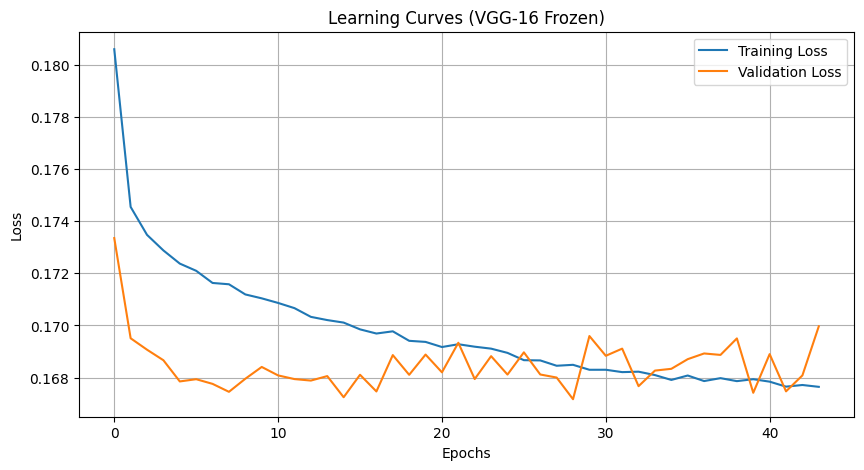


2: Training VGG-16 with half conv layers frozen


Epoch 1/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.66it/s]


Epoch 1/100 | Train Loss: 0.1768 | Val Loss: 0.1640
Validation loss decreased (inf --> 0.164048).  Saving model ...


Epoch 2/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.80it/s]


Epoch 2/100 | Train Loss: 0.1647 | Val Loss: 0.1616
Validation loss decreased (0.164048 --> 0.161607).  Saving model ...


Epoch 3/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.73it/s]


Epoch 3/100 | Train Loss: 0.1594 | Val Loss: 0.1585
Validation loss decreased (0.161607 --> 0.158519).  Saving model ...


Epoch 4/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.58it/s]


Epoch 4/100 | Train Loss: 0.1541 | Val Loss: 0.1575
Validation loss decreased (0.158519 --> 0.157505).  Saving model ...


Epoch 5/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.72it/s]


Epoch 5/100 | Train Loss: 0.1474 | Val Loss: 0.1575
EarlyStopping counter: 1 out of 15


Epoch 6/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.67it/s]


Epoch 6/100 | Train Loss: 0.1376 | Val Loss: 0.1627
EarlyStopping counter: 2 out of 15


Epoch 7/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.67it/s]


Epoch 7/100 | Train Loss: 0.1241 | Val Loss: 0.1773
EarlyStopping counter: 3 out of 15


Epoch 8/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.67it/s]


Epoch 8/100 | Train Loss: 0.1082 | Val Loss: 0.1910
EarlyStopping counter: 4 out of 15


Epoch 9/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.79it/s]


Epoch 9/100 | Train Loss: 0.0925 | Val Loss: 0.2254
EarlyStopping counter: 5 out of 15


Epoch 10/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.61it/s]


Epoch 10/100 | Train Loss: 0.0778 | Val Loss: 0.2536
EarlyStopping counter: 6 out of 15


Epoch 11/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.71it/s]


Epoch 11/100 | Train Loss: 0.0668 | Val Loss: 0.3019
EarlyStopping counter: 7 out of 15


Epoch 12/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.75it/s]


Epoch 12/100 | Train Loss: 0.0575 | Val Loss: 0.3355
EarlyStopping counter: 8 out of 15


Epoch 13/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.78it/s]


Epoch 13/100 | Train Loss: 0.0509 | Val Loss: 0.3556
EarlyStopping counter: 9 out of 15


Epoch 14/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.71it/s]


Epoch 14/100 | Train Loss: 0.0455 | Val Loss: 0.3565
EarlyStopping counter: 10 out of 15


Epoch 15/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.79it/s]


Epoch 15/100 | Train Loss: 0.0406 | Val Loss: 0.4328
EarlyStopping counter: 11 out of 15


Epoch 16/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.89it/s]


Epoch 16/100 | Train Loss: 0.0374 | Val Loss: 0.4339
EarlyStopping counter: 12 out of 15


Epoch 17/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.76it/s]


Epoch 17/100 | Train Loss: 0.0346 | Val Loss: 0.4387
EarlyStopping counter: 13 out of 15


Epoch 18/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.78it/s]


Epoch 18/100 | Train Loss: 0.0318 | Val Loss: 0.4666
EarlyStopping counter: 14 out of 15


Epoch 19/100 [Val]: 100%|██████████| 351/351 [00:19<00:00, 17.73it/s]


Epoch 19/100 | Train Loss: 0.0299 | Val Loss: 0.4710
EarlyStopping counter: 15 out of 15
Early stopping triggered.
Training finished in 3377.63 seconds.

Evaluating VGG-16 (Half-Frozen) on Test Data
Test AUC: 0.7673, Test Accuracy: 0.9479


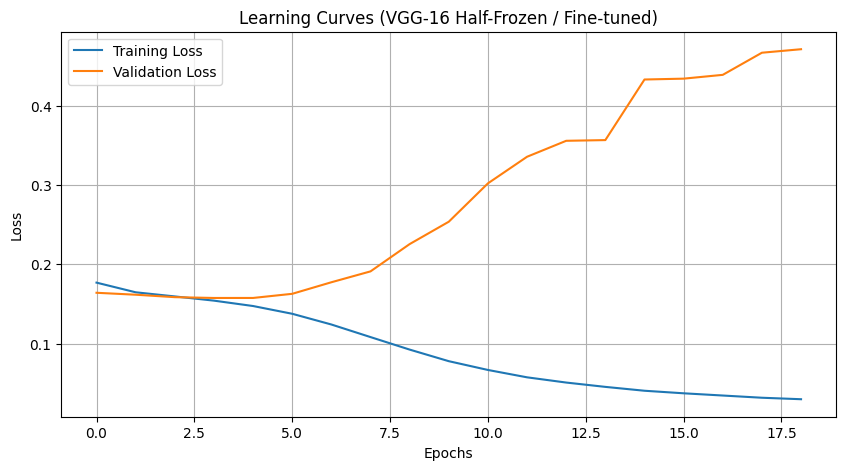

In [16]:
print("\n" + "-"*30)
print("2b - Transfer Learning with VGG-16")
print("-"*30)

vgg_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet stats
])

# Create new datasets and dataloaders with VGG transformations
train_dataset_vgg = DataClass(split='train', transform=vgg_transform, download=True)
val_dataset_vgg = DataClass(split='val', transform=vgg_transform, download=True)
test_dataset_vgg = DataClass(split='test', transform=vgg_transform, download=True)

train_loader_vgg = DataLoader(dataset=train_dataset_vgg, batch_size=32, shuffle=True)
val_loader_vgg = DataLoader(dataset=val_dataset_vgg, batch_size=32, shuffle=False)
test_loader_vgg = DataLoader(dataset=test_dataset_vgg, batch_size=64, shuffle=False)

def get_vgg_model(freeze_level):
    """
    Loads a VGG-16 model and modifies it for our task.
    freeze_level = 'all': freezes all convolutional layers.
    freeze_level = 'half': freezes the first half of conv layers.
    """
    # Load pre-trained VGG-16
    vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    # Freeze layers based on the setting
    if freeze_level == 'all':
        for param in vgg16.features.parameters():
            param.requires_grad = False
    elif freeze_level == 'half':
        # VGG-16 has 13 conv layers. We freeze roughly half.
        # Layers are in vgg16.features which is a Sequential module.
        # Freeze up to layer index 16 (which includes the first 7 conv layers)
        for i, child in enumerate(vgg16.features.children()):
            if i < 16:
                for param in child.parameters():
                    param.requires_grad = False

    num_features_after_conv = 512

    new_head = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
        nn.Flatten(),
        nn.Linear(num_features_after_conv, 1024), # First FC Layer
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(1024, 512), # Second FC Layer
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(512, n_classes) # Final Output Layer
    )

    class CustomVGG_for_transfer_learning(nn.Module):
        def __init__(self, features, head):
            super(CustomVGG_for_transfer_learning, self).__init__()
            self.features = features
            self.classifier = head

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    model = CustomVGG_for_transfer_learning(vgg16.features, new_head)

    return model.to(DEVICE)


# Freeze all convolutional layers
print("\n1: Training VGG-16 with all conv layers frozen")
vgg_frozen = get_vgg_model('all')
optimizer_frozen = optim.Adam(vgg_frozen.classifier.parameters(), lr=LR)
vgg_frozen_path = os.path.join(MODEL_PATH, "vgg_frozen.pt")
history_vgg_frozen = train_model(
    vgg_frozen, train_loader_vgg, val_loader_vgg, criterion, optimizer_frozen, epochs=EPOCHS, model_save_path=vgg_frozen_path
)

print("\nEvaluating VGG-16 (Frozen) on Test Data")
eval_model_frozen = get_vgg_model('all')
eval_model_frozen.load_state_dict(torch.load(vgg_frozen_path))
auc_vgg_frozen, acc_vgg_frozen = evaluate_model(eval_model_frozen, test_loader_vgg)
print(f"Test AUC: {auc_vgg_frozen:.4f}, Test Accuracy: {acc_vgg_frozen:.4f}")
plot_learning_curves(history_vgg_frozen, "Learning Curves (VGG-16 Frozen)")

# Freeze half of the convolutional layers
print("\n2: Training VGG-16 with half conv layers frozen")
vgg_halffrozen = get_vgg_model('half')
optimizer_halffrozen = optim.Adam(vgg_halffrozen.parameters(), lr=LR/10) # Using lower LR for fine-tuning
vgg_halffrozen_path = os.path.join(MODEL_PATH, "vgg_halffrozen.pt")
history_vgg_halffrozen = train_model(
    vgg_halffrozen, train_loader_vgg, val_loader_vgg, criterion, optimizer_halffrozen, epochs=EPOCHS, model_save_path=vgg_halffrozen_path
)

print("\nEvaluating VGG-16 (Half-Frozen) on Test Data")
eval_model_halffrozen = get_vgg_model('half')
eval_model_halffrozen.load_state_dict(torch.load(vgg_halffrozen_path))
auc_vgg_halffrozen, acc_vgg_halffrozen = evaluate_model(eval_model_halffrozen, test_loader_vgg)
print(f"Test AUC: {auc_vgg_halffrozen:.4f}, Test Accuracy: {acc_vgg_halffrozen:.4f}")
plot_learning_curves(history_vgg_halffrozen, "Learning Curves (VGG-16 Half-Frozen / Fine-tuned)")

In [17]:
print(f"Fully Frozen -> AUC: {auc_vgg_frozen:.4f}, Accuracy: {acc_vgg_frozen:.4f}")
print(f"Half Frozen  -> AUC: {auc_vgg_halffrozen:.4f}, Accuracy: {acc_vgg_halffrozen:.4f}")

Fully Frozen -> AUC: 0.7191, Accuracy: 0.9475
Half Frozen  -> AUC: 0.7673, Accuracy: 0.9479


#### 2c)


------------------------------
2c: Grad-CAM Visualization
------------------------------
Generating Grad-CAM heatmaps for 5 images from each class...


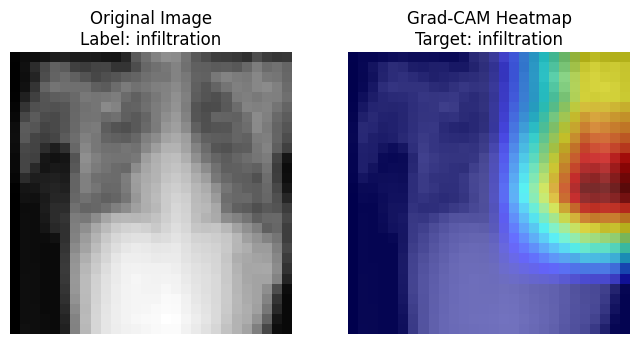

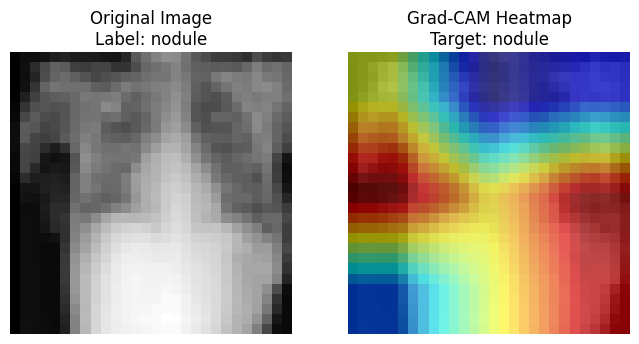

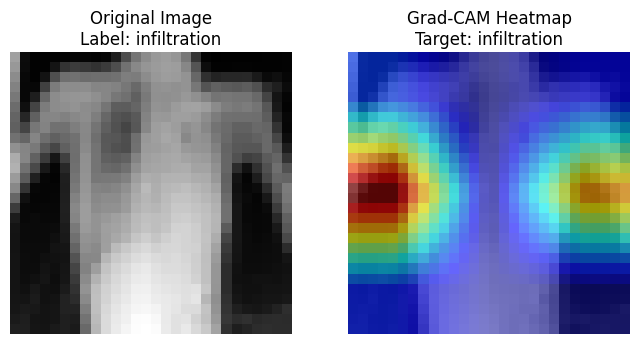

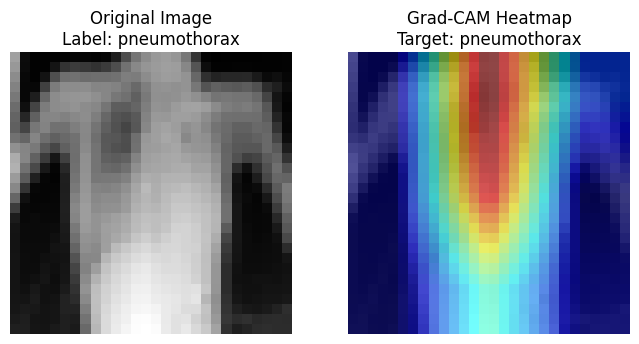

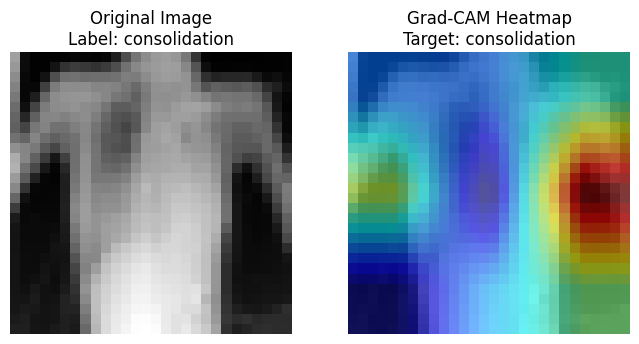

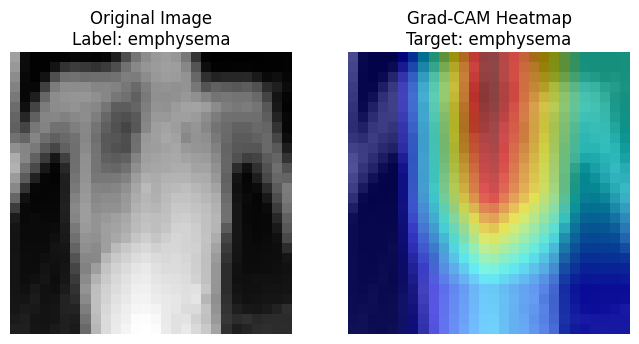

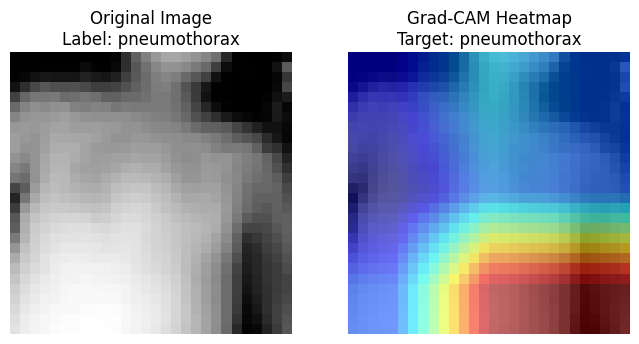

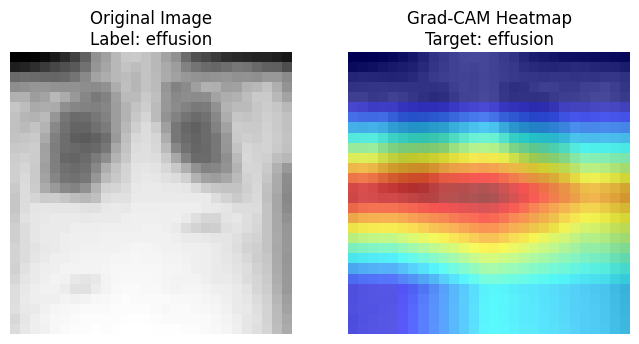

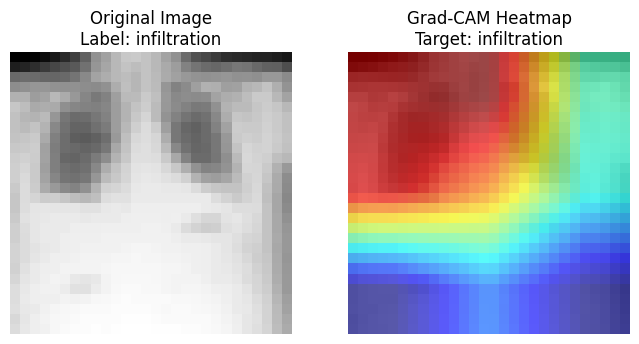

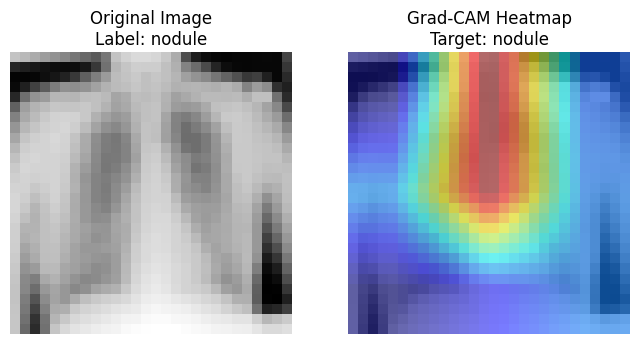

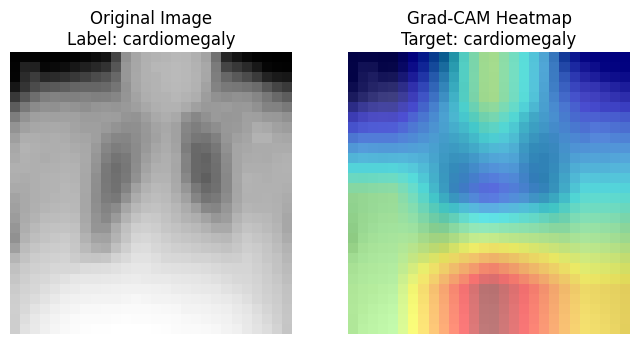

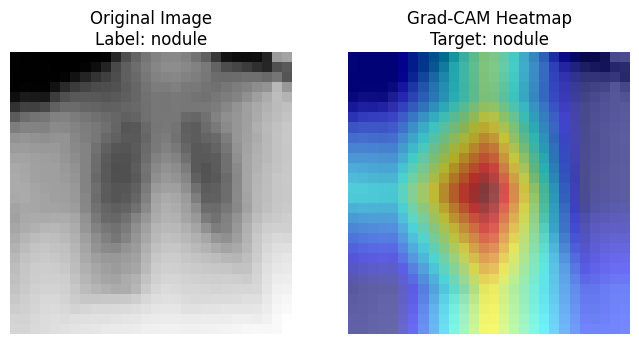

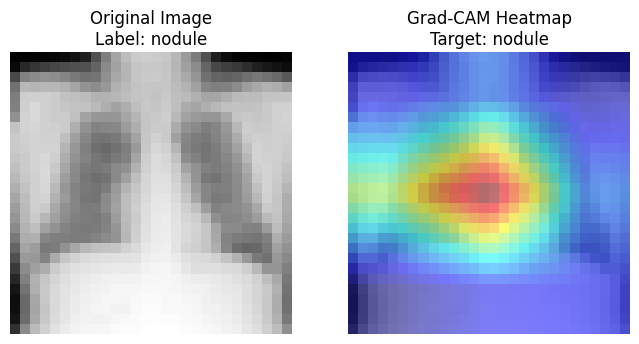

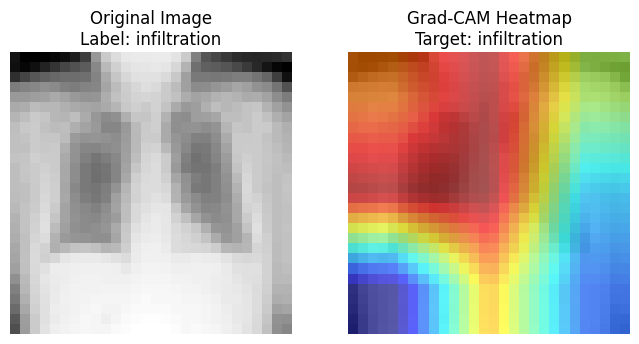

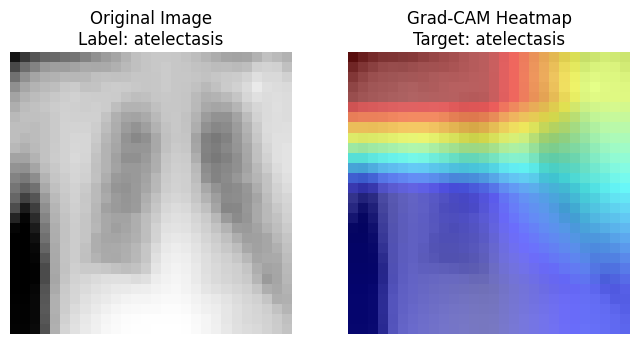

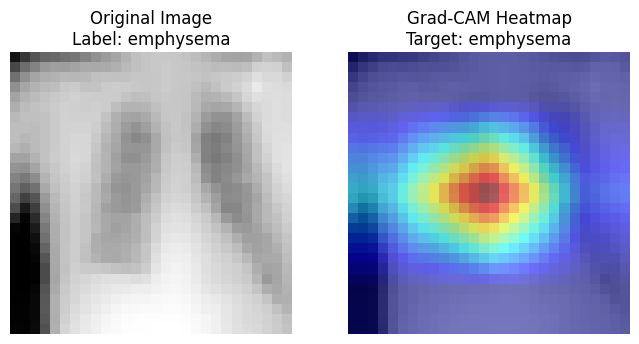

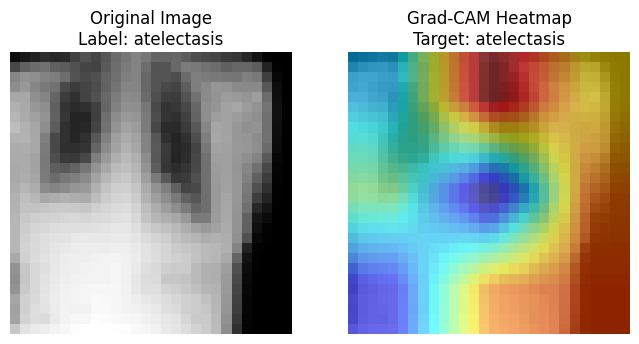

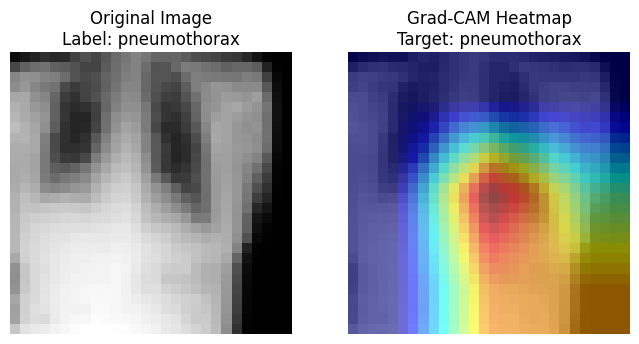

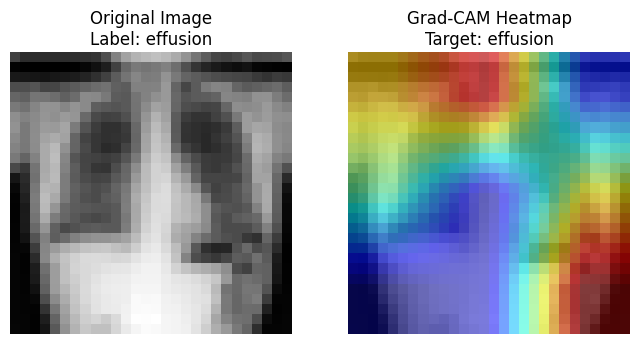

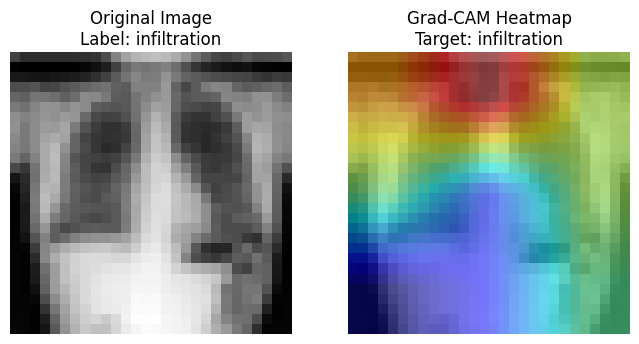

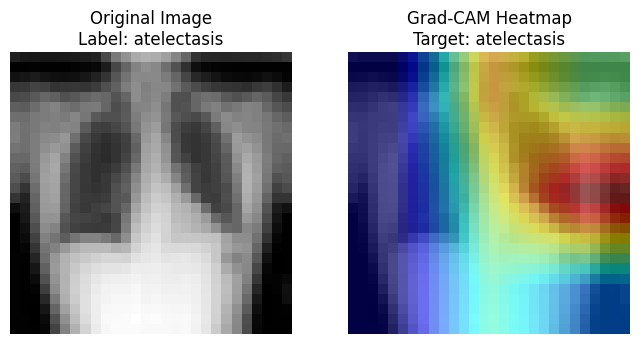

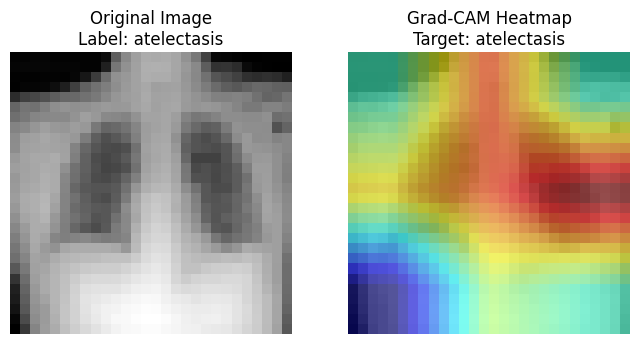

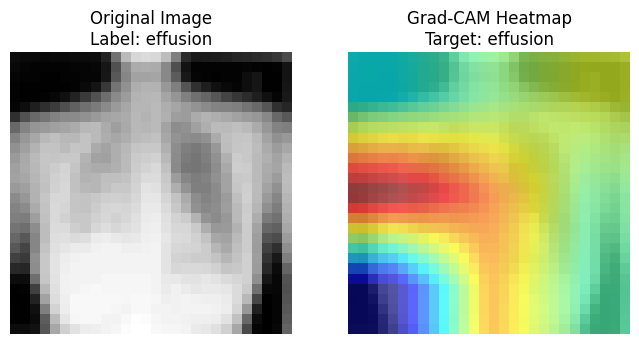

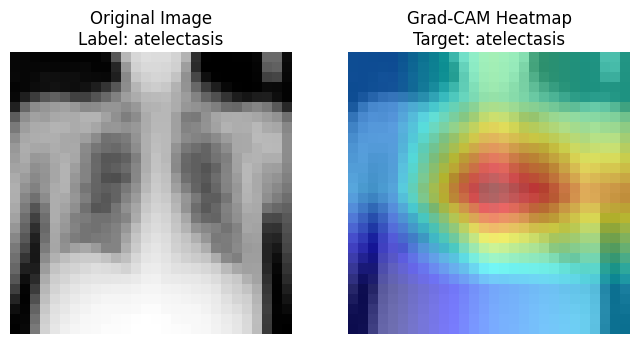

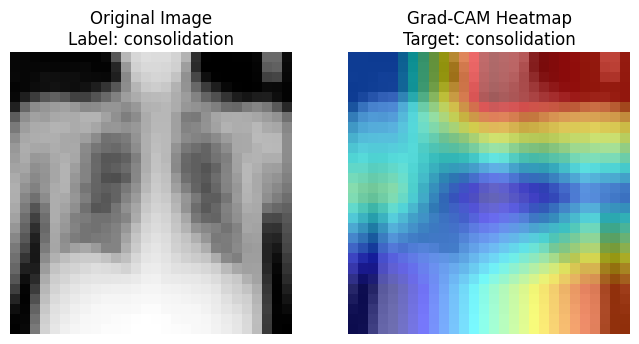

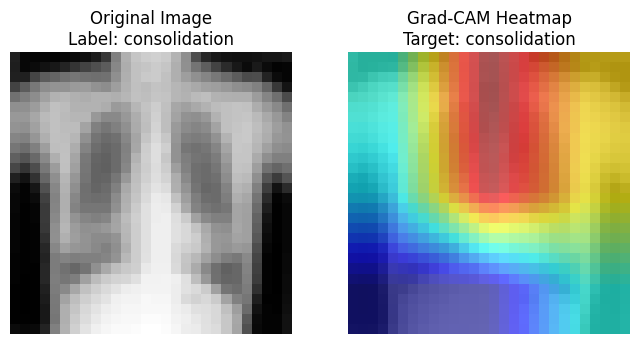

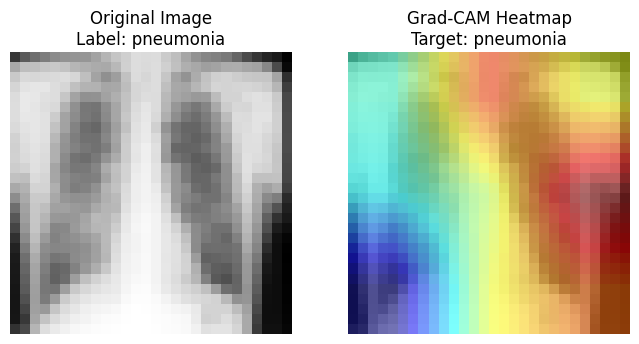

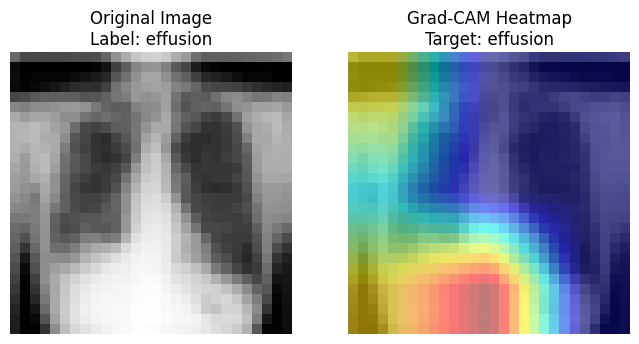

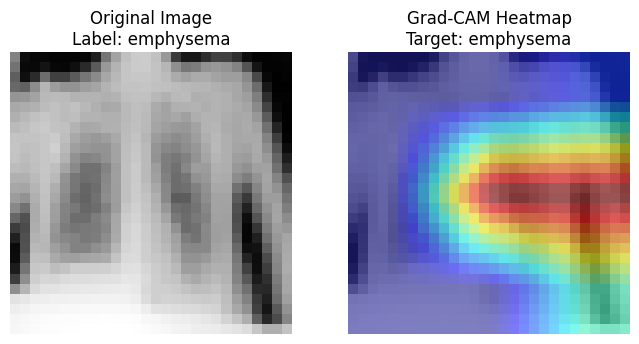

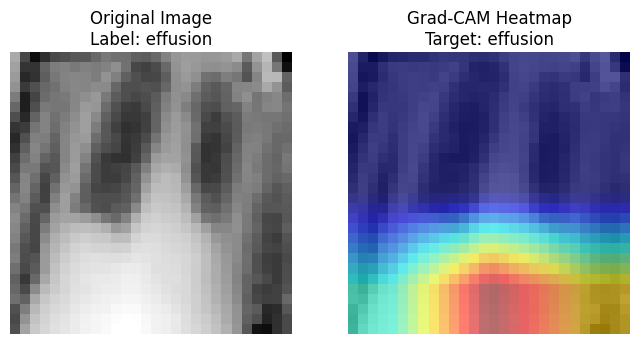

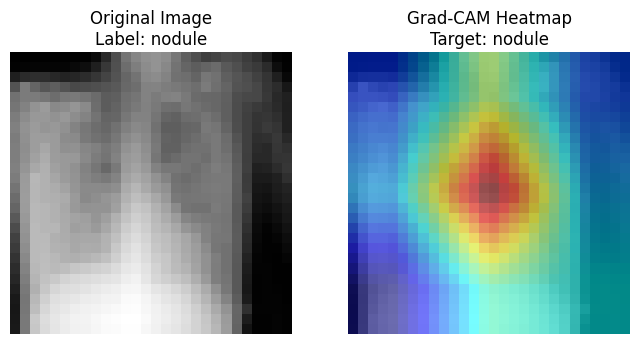

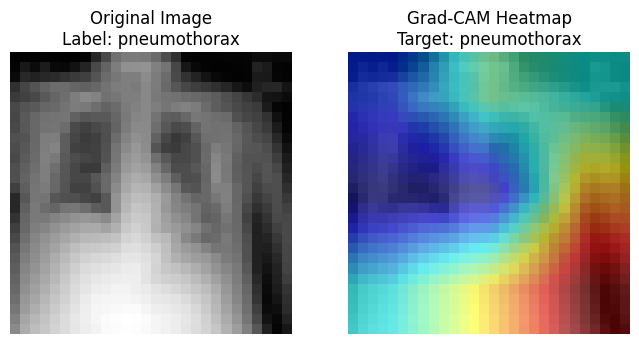

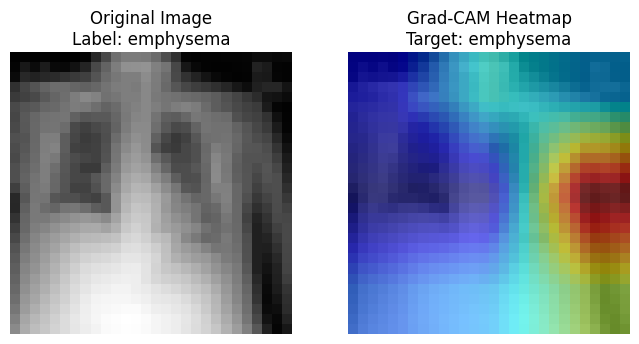

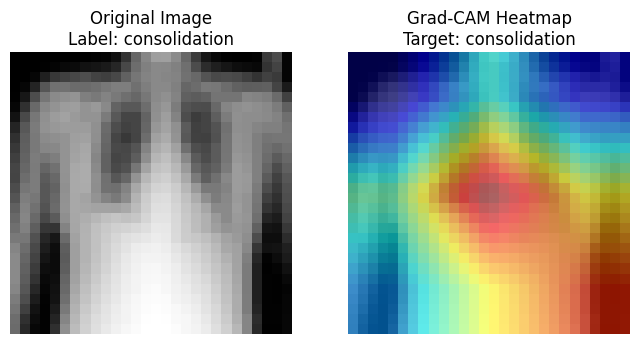

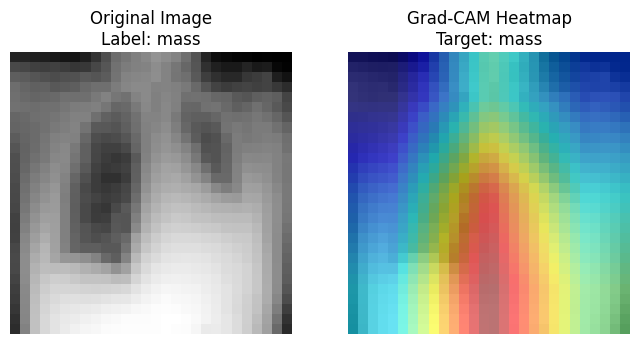

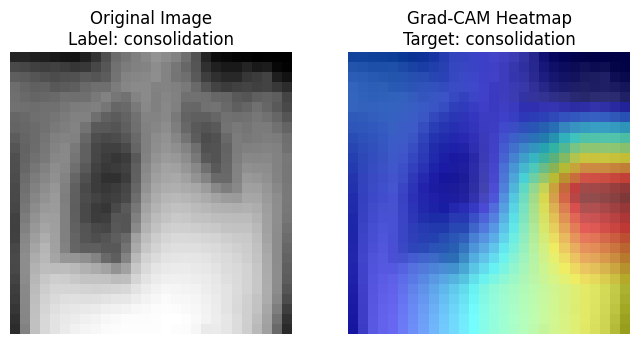

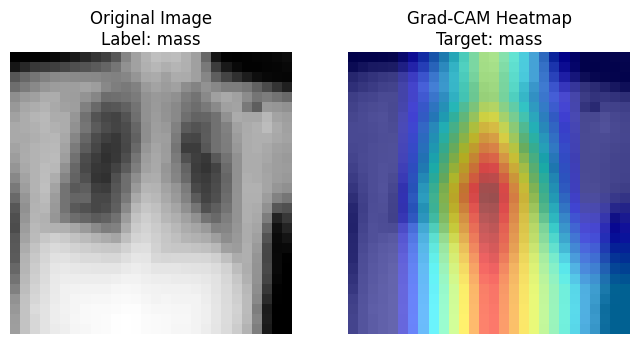

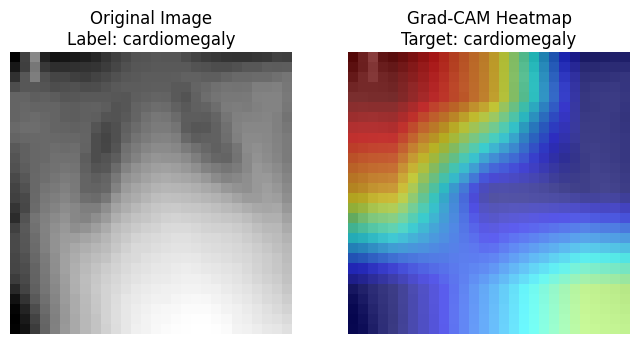

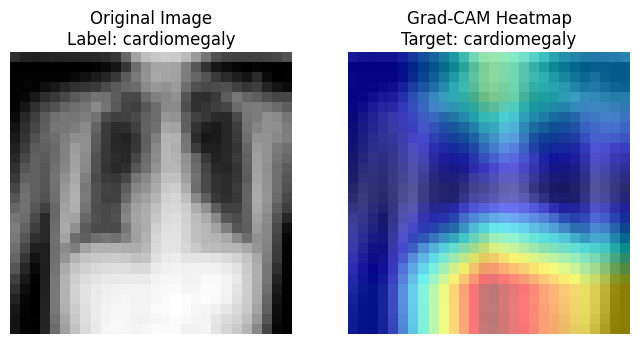

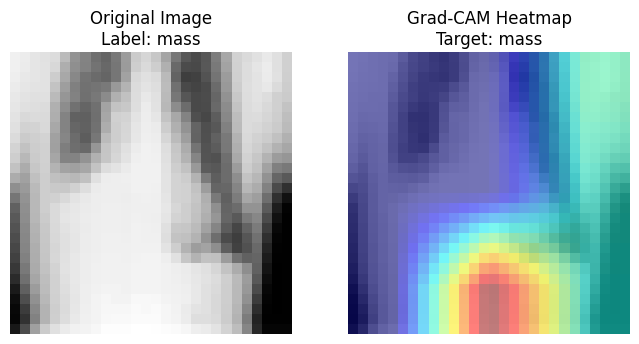

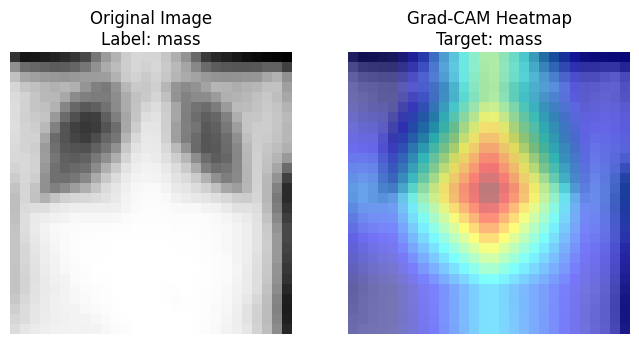

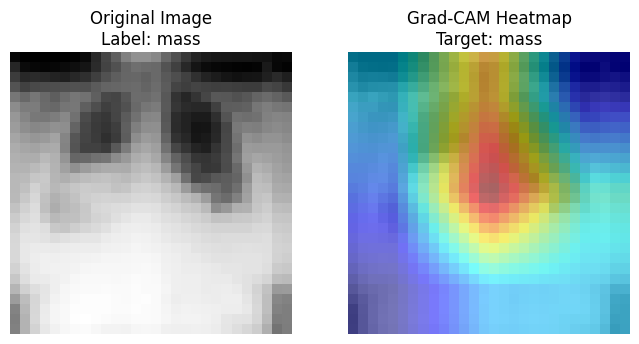

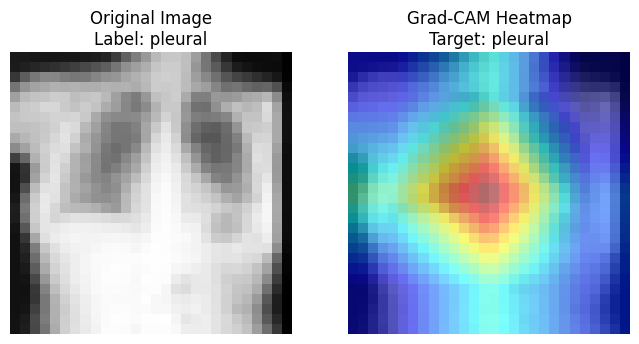

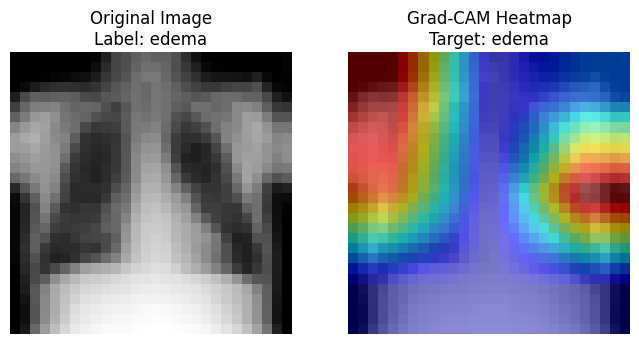

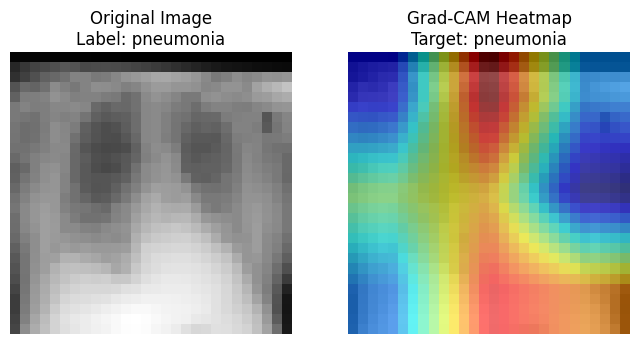

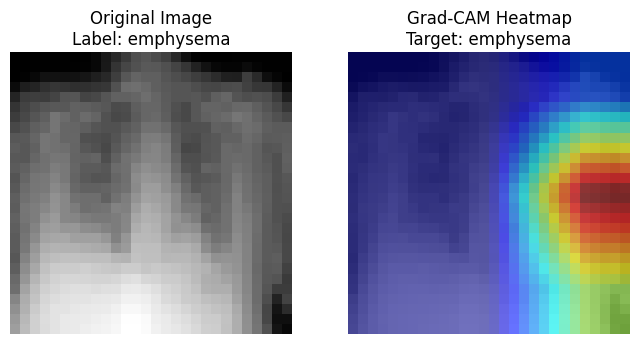

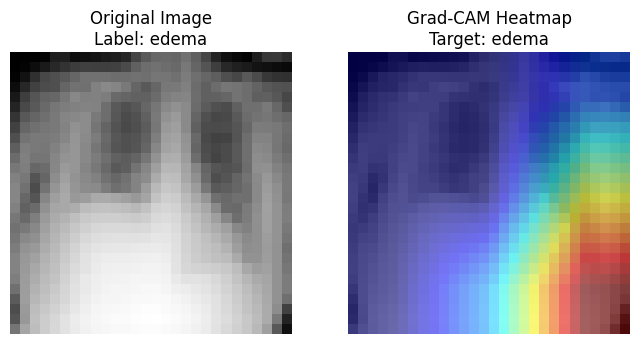

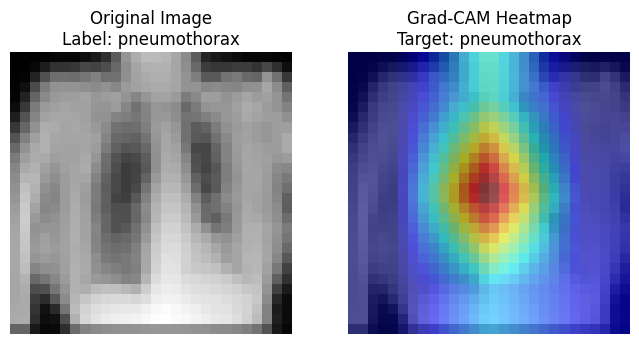

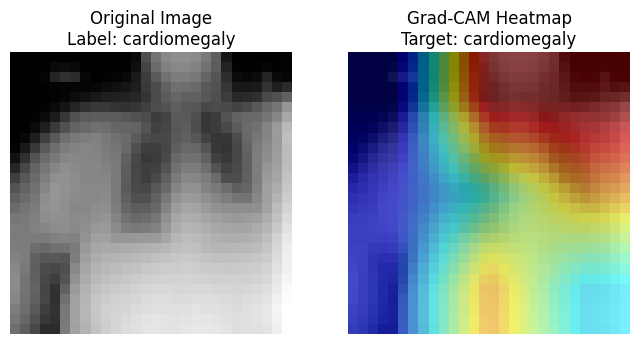

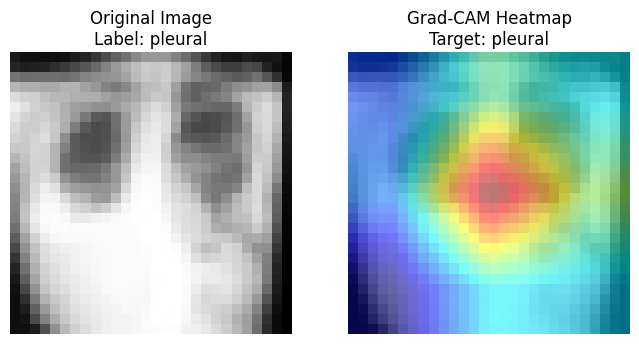

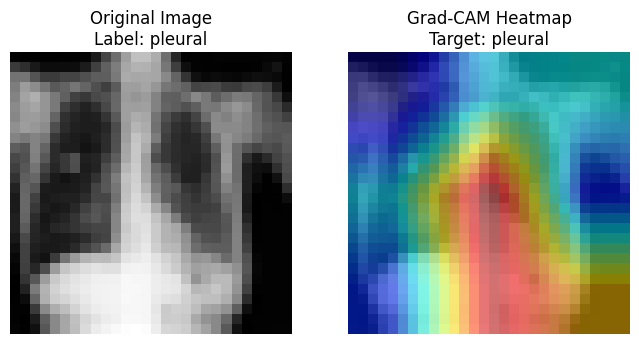

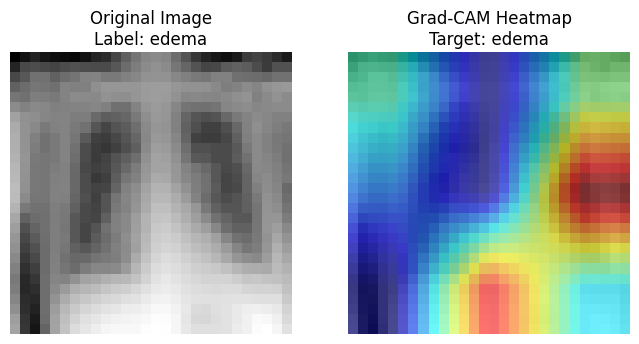

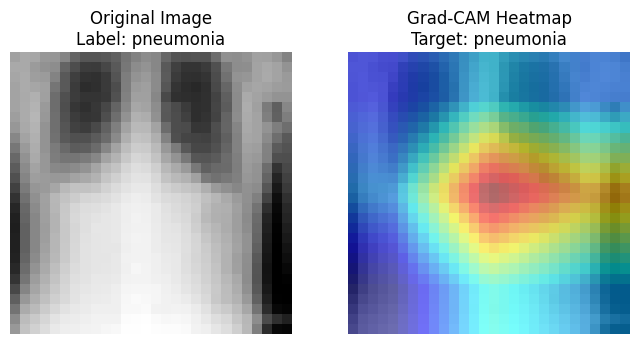

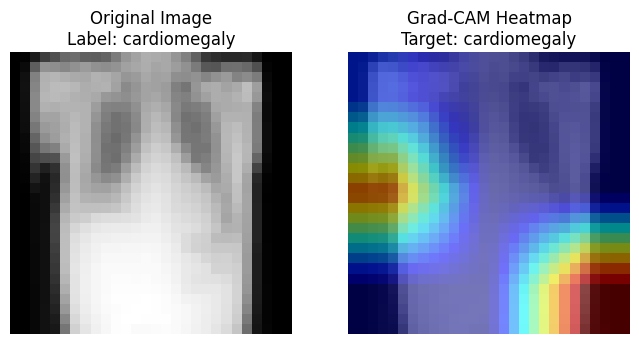

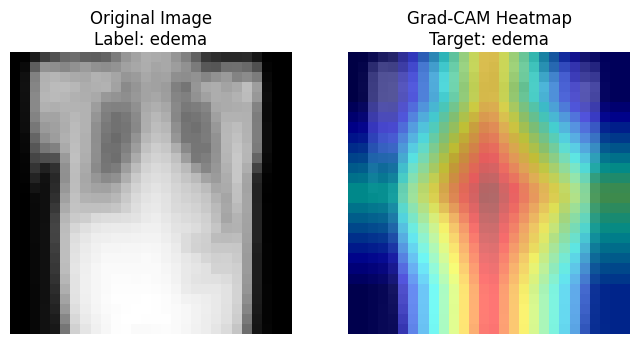

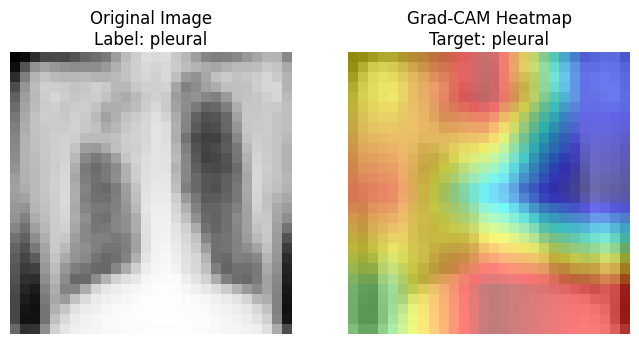

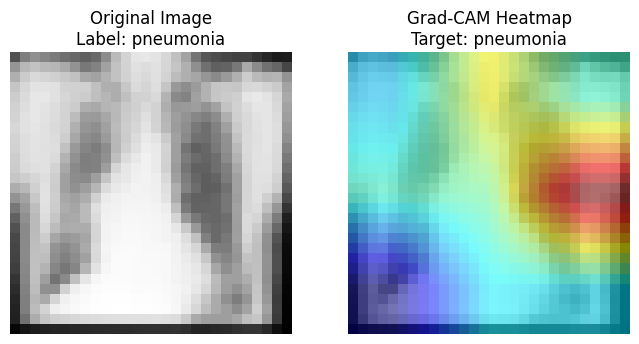

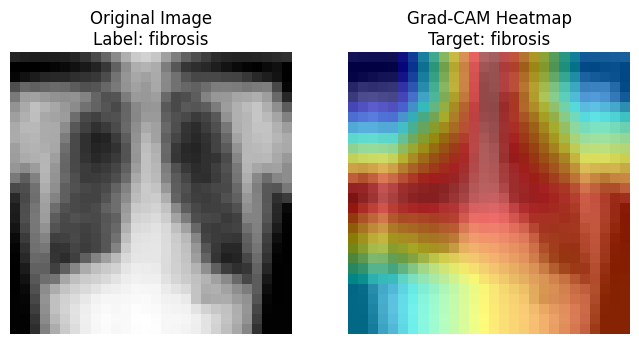

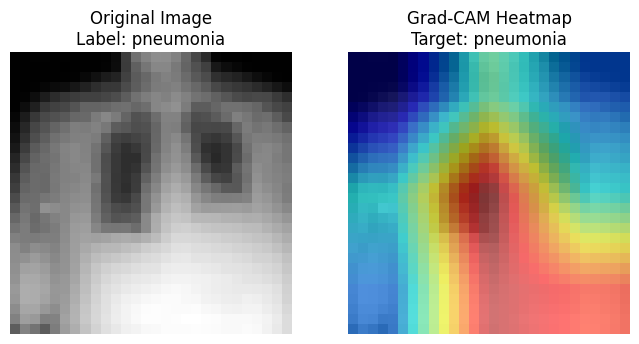

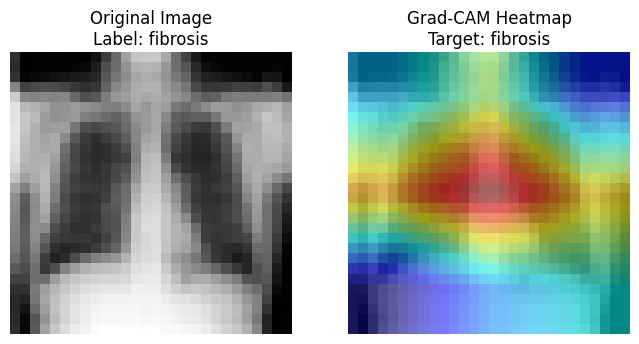

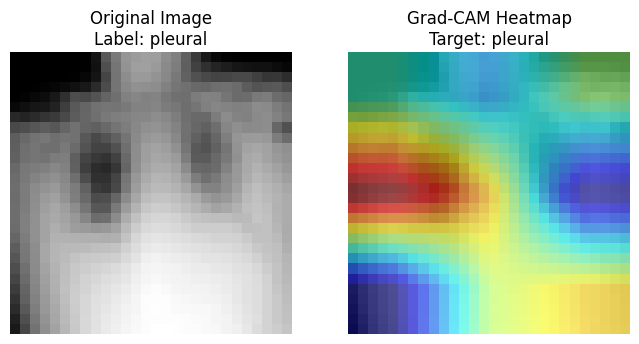

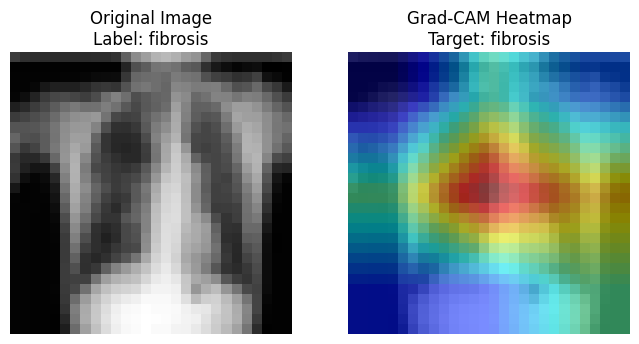

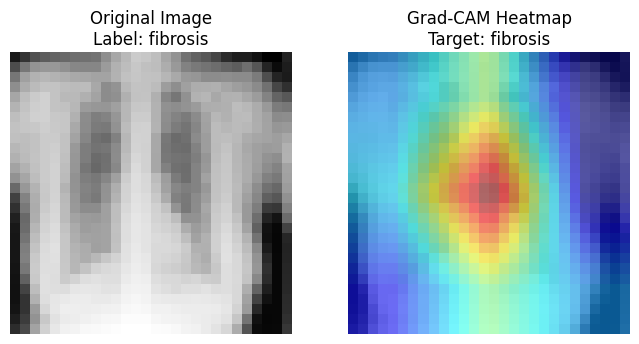

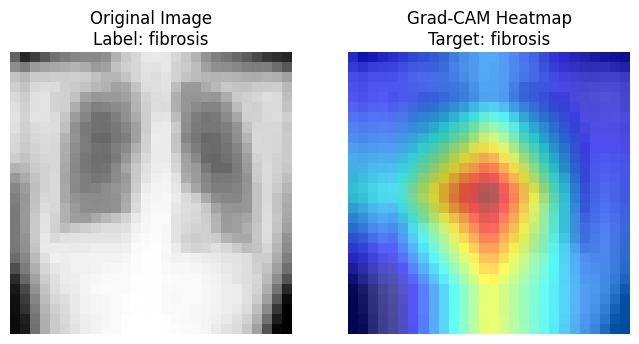

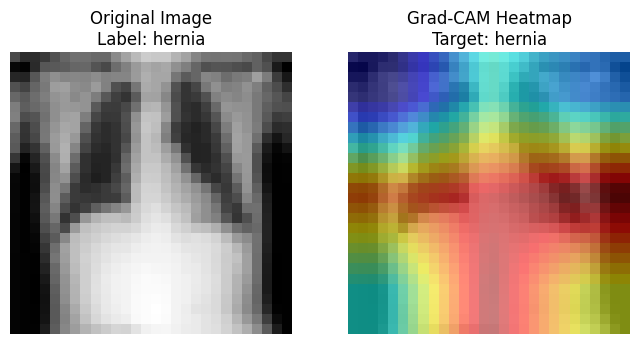

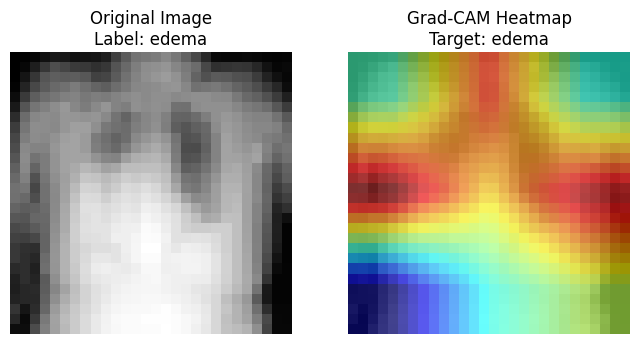

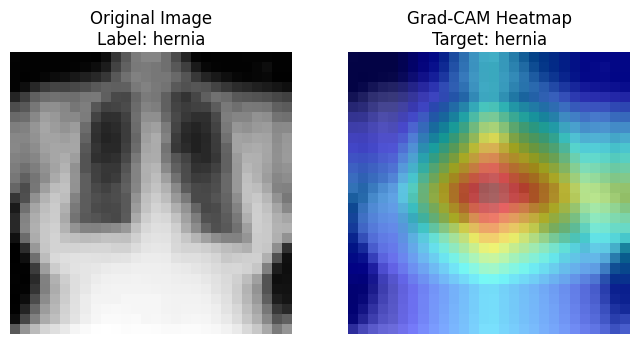

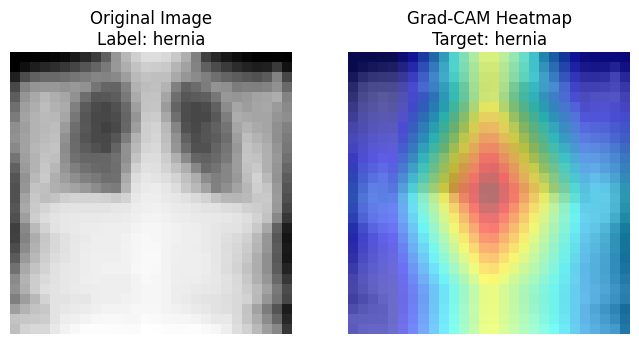

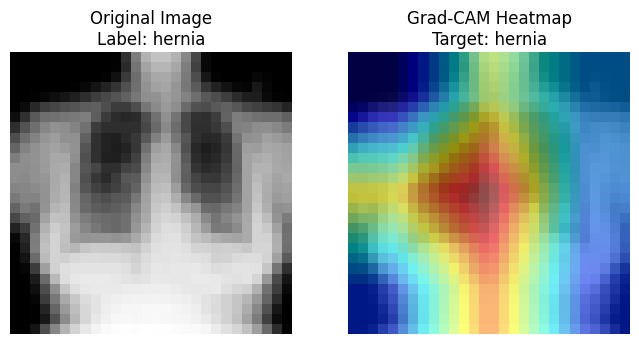

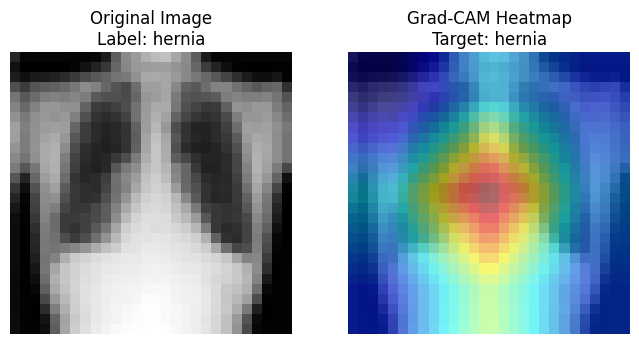

Generated required number of visualizations for all classes.


In [18]:
print("\n" + "-"*30)
print("2c: Grad-CAM Visualization")
print("-"*30)

grad_cam_model = DeepCNN_with_3_cl(in_channels=n_channels, num_classes=n_classes).to(DEVICE)
grad_cam_model.load_state_dict(torch.load(model_with_aug_path))
grad_cam_model.eval()

target_layers = [grad_cam_model.conv_block4[0]]
cam = GradCAM(model=grad_cam_model, target_layers=target_layers)

def generate_grad_cam_visualizations(dataset, model, num_images_per_class=5):
    """Generates and displays Grad-CAM heatmaps."""
    # Create a dictionary that maps integer keys to string labels
    idx_to_label = {int(k): v for k, v in labels.items()}
    visualized_counts = {i: 0 for i in range(n_classes)}

    # Iterate over zipped images and labels.
    for i, (img_np, target_labels) in enumerate(zip(dataset.imgs, dataset.labels)):
        # Checking if we still need to find an image for any class
        needs_viz = any(visualized_counts[label_idx] < num_images_per_class for label_idx in np.where(target_labels == 1)[0])
        if not needs_viz: continue

        input_tensor = data_transform_no_aug(img_np).unsqueeze(0).to(DEVICE)
        # Converting single channel grayscale to a 3-channel image for visualization
        rgb_img = np.stack([img_np.squeeze()] * 3, axis=-1)
        rgb_img = np.float32(rgb_img) / 255

        # Iterating through the labels present in this image
        for class_idx in np.where(target_labels == 1)[0]:
            if visualized_counts[class_idx] < num_images_per_class:
                targets = [ClassifierOutputTarget(class_idx)]
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
                visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1); plt.imshow(img_np, cmap='gray'); plt.title(f"Original Image\nLabel: {idx_to_label[class_idx]}"); plt.axis('off')
                plt.subplot(1, 2, 2); plt.imshow(visualization); plt.title(f"Grad-CAM Heatmap\nTarget: {idx_to_label[class_idx]}"); plt.axis('off')
                plt.show()

                visualized_counts[class_idx] += 1

        # Stop if we have found enough images for all classes
        if all(count >= num_images_per_class for count in visualized_counts.values()):
            print("Generated required number of visualizations for all classes.")
            break

print("Generating Grad-CAM heatmaps for 5 images from each class...")
generate_grad_cam_visualizations(train_dataset_no_aug, grad_cam_model, num_images_per_class=5)

In [19]:
print("\n" + "-"*30)
print("2d: Model Quantization")
print("-"*30)

def print_model_size(model, label):
    """Calculates and prints the size of a model."""
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p") / 1e6
    print(f"Size of {label} model: {size_mb:.2f} MB")
    os.remove("temp.p")
    return size_mb

# CPU model to be the source for all quantization
# This prevents device state from leaking from the FP32 evaluation.
base_model_cpu = DeepCNN_with_3_cl(in_channels=n_channels, num_classes=n_classes).to("cpu")
base_model_cpu.load_state_dict(torch.load(model_with_aug_path, map_location="cpu"))
base_model_cpu.eval()

# Evaluation of Original FP32 Model

fp32_eval_model = copy.deepcopy(base_model_cpu).to(DEVICE)
auc_original, acc_original = evaluate_model(fp32_eval_model, test_loader)
size_original = print_model_size(base_model_cpu, "Original FP32")


# Post-Training Dynamic Quantization
print("\n1. Post-Training Dynamic Quantization")
# Use a clean copy of the CPU base model
dynamic_quantized_model = torch.quantization.quantize_dynamic(
    copy.deepcopy(base_model_cpu), {nn.Linear}, dtype=torch.qint8
)
auc_dynamic, acc_dynamic = evaluate_quantized_model(dynamic_quantized_model, test_loader)
size_dynamic = print_model_size(dynamic_quantized_model, "Dynamic Quantized")

# Post-Training Static Quantization (Full Integer)
print("\n2. Post-Training Static Quantization (Full Integer)")
# Use a clean copy of the CPU base model
static_model_to_quantize = copy.deepcopy(base_model_cpu)
static_model_to_quantize.eval()
static_model_to_quantize.qconfig = torch.quantization.get_default_qconfig('fbgemm')
static_quantized_model = torch.quantization.prepare(static_model_to_quantize, inplace=False)

def calibrate_model(model, loader, num_batches=10):
    model.eval()
    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            if i >= num_batches: break
            model(images)
print("Calibrating model for static quantization...")
# Use a data loader with non-augmented data for calibration
calibrate_loader = DataLoader(dataset=train_dataset_no_aug, batch_size=BATCH_SIZE, shuffle=True)
calibrate_model(static_quantized_model, calibrate_loader)
torch.quantization.convert(static_quantized_model, inplace=True)
auc_static, acc_static = evaluate_quantized_model(static_quantized_model, test_loader)
size_static = print_model_size(static_quantized_model, "Static Quantized")

# Quantization-Aware Training
print("\n3. Quantization-Aware Training (QAT)")
qat_model = copy.deepcopy(base_model_cpu)
qat_model.train() # Set to train mode for QAT
qat_model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(qat_model, inplace=True)

print("Fine-tuning model with Quantization-Aware Training...")
# Use a smaller learning rate for fine-tuning
optimizer_qat = torch.optim.Adam(qat_model.parameters(), lr=LR/100)
# Run for a few epochs for QAT
for epoch in range(3):
    for images, labels in tqdm(train_loader_with_aug, desc=f"QAT Epoch {epoch+1}"):
        images, labels = images.to("cpu"), labels.to("cpu") # QAT runs on CPU
        optimizer_qat.zero_grad()
        output = qat_model(images)
        loss = criterion(output, labels.float())
        loss.backward()
        optimizer_qat.step()

qat_model.eval()
qat_model_quantized = torch.quantization.convert(qat_model, inplace=False)
auc_qat, acc_qat = evaluate_quantized_model(qat_model_quantized, test_loader)
size_qat = print_model_size(qat_model_quantized, "QAT Quantized")


------------------------------
2d: Model Quantization
------------------------------
Size of Original FP32 model: 6.32 MB

1. Post-Training Dynamic Quantization


/tmp/ipython-input-3296478153.py:29: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  dynamic_quantized_model = torch.quantization.quantize_dynamic(


Size of Dynamic Quantized model: 2.76 MB

2. Post-Training Static Quantization (Full Integer)
Calibrating model for static quantization...


/tmp/ipython-input-3296478153.py:41: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  static_quantized_model = torch.quantization.prepare(static_model_to_quantize, inplace=False)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range w

Size of Static Quantized model: 1.62 MB

3. Quantization-Aware Training (QAT)
Fine-tuning model with Quantization-Aware Training...


QAT Epoch 3: 100%|██████████| 614/614 [01:34<00:00,  6.51it/s]
/tmp/ipython-input-3296478153.py:78: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  qat_model_quantized = torch.quantization.convert(qat_model, inplace=False)


Size of QAT Quantized model: 1.62 MB


In [21]:
print("\nQuantization Techniques Comparison of different models :- ")
print(f"{'Method Name ':<30} | {'Model Size in mb':<20} | {'Test Accuracy score':<15} | {'Test AUC score':<15}")
print("-" * 85)
print(f"{' 1. Original FP32':<30} | {size_original:<20.2f} | {acc_original:<15.4f} | {auc_original:<15.4f}")
print(f"{' 2. Dynamic Quantization':<30} | {size_dynamic:<20.2f} | {acc_dynamic:<15.4f} | {auc_dynamic:<15.4f}")
print(f"{' 3. Static Quantization':<30} | {size_static:<20.2f} | {acc_static:<15.4f} | {auc_static:<15.4f}")
print(f"{' 4. Quantization-Aware Training':<30} | {size_qat:<20.2f} | {acc_qat:<15.4f} | {auc_qat:<15.4f}")


Quantization Techniques Comparison of different models :- 
Method Name                    | Model Size in mb     | Test Accuracy score | Test AUC score 
-------------------------------------------------------------------------------------
 1. Original FP32              | 6.32                 | 0.9478          | 0.7588         
 2. Dynamic Quantization       | 2.76                 | 0.9478          | 0.7587         
 3. Static Quantization        | 1.62                 | 0.9478          | 0.7570         
 4. Quantization-Aware Training | 1.62                 | 0.9480          | 0.7632         
